In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error

In [2]:
%matplotlib notebook
plt.style.use('seaborn-whitegrid')

In [3]:
def split_xy(df):
    y = df.Spo_decr
    x = df.drop('Spo_decr', axis=1)
    return x, y

In [4]:
def get_correlation_and_r2_patfold(gt, pred, mae):

    gt = pd.DataFrame(np.array(gt).reshape(gt.shape[0], 1))
    pred = pd.DataFrame(pred.reshape(pred.shape[0], 1))
    ccorr = pd.concat([gt, pred], axis=1).corr()
    r2 = r2_score(gt, pred)
    return ccorr, r2


def get_correlation_and_r2(gt, pred, mae):
    
    less_mae_idx = np.argmin(mae)
    new_shape = (pred[less_mae_idx].shape[0], 1)
    a = pd.DataFrame(pred[less_mae_idx].reshape(new_shape))
    b = pd.DataFrame(np.array(gt[less_mae_idx]).reshape(new_shape))
    ccorr = pd.concat([b, a], axis=1).corr()
    r2 = r2_score(b, a)
    return ccorr, r2

In [5]:
from keras import models 
from keras import layers
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


In [25]:
pat_indexes

,0
0,0
1,296
2,578
3,811


In [6]:
def evaluate_model_shuffle(model, X, y, splitter, n_epochs):
       
    all_mae_histories = []
    all_mae_histories_val = []
    ground_truth = []
    predictions = []
    
    shuffled_data = pd.concat([X, y], axis=1).sample(frac=1)
    test_indexes = int(len(shuffled_data.index)*0.3)
    test_data = shuffled_data.iloc[:test_indexes]
    train_data = shuffled_data.iloc[test_indexes:]
    
    X_train, y_train = split_xy(train_data)
    X_test, y_test = split_xy(test_data)
    print('Train data shape:{}, Test data shape:{}'.format(X_train.shape, X_test.shape))

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=n_epochs, verbose=1, batch_size=1)

    ground_truth.append(y_test)
    preds = model.predict(X_test)
    predictions.append(preds)

    mae_history = history.history['mean_absolute_error']
    mea_history_val = mean_absolute_error(preds, y_test)

    all_mae_histories.append(mae_history)
    all_mae_histories_val.append(mea_history_val)
           
    average_mae_history = [
                np.mean([x[i] for x in all_mae_histories]) for i in range(n_epochs)]
    
    average_mae_history_val = [
                np.mean([x for x in all_mae_histories_val]) for i in range(n_epochs)]
    
    return model, average_mae_history, average_mae_history_val, ground_truth, predictions


In [91]:
def evaluate_model_shuffle2(model, X, y, splitter, n_folds, n_epochs):
       
    all_fold_mae = []
    all_fold_mae_val = []
    ground_truth = []
    predictions = []
    
    shuffled_data = pd.concat([X, y], axis=1).sample(frac=1)
    
    fold_idx = int(len(shuffled_data.index)//n_folds)
    
    for fold in range(n_folds):
        fi_next = fold + 1
        if fold == 0:
            test_data = shuffled_data.iloc[:fold_idx, :]
            train_data = shuffled_data.iloc[fold_idx:, :]
        elif fold == n_folds-1:
            test_data = shuffled_data.iloc[fold_idx*fold:, :]
            train_data = shuffled_data.iloc[:fold_idx*fold, :]
        else:
            test_data = shuffled_data.iloc[fold_idx*fold:fold_idx*(fi_next), :]
            train_data = pd.concat([shuffled_data.iloc[:fold_idx*fold, :], 
                                        shuffled_data.iloc[fold_idx*(fi_next):, :]], axis=0) 

        X_train, y_train = splitter(train_data)
        X_test, y_test = splitter(test_data)
        print('#################--FOLD №{}--#################'.format(fi_next))
        print('Train data shape:{}, Test data shape:{}'.format(X_train.shape, X_test.shape))

        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=n_epochs, verbose=1, batch_size=1)

        ground_truth.append(y_test)
        preds = model.predict(X_test)
        predictions.append(preds)
        
        mae_history = history.history['mean_absolute_error']
        mae_history_val = history.history['val_mean_absolute_error']

        all_fold_mae.append(mae_history)
        all_fold_mae_val.append(mae_history_val)

    average_mae_history = np.mean(all_fold_mae, axis=0) 
    average_mae_history_val = np.mean(all_fold_mae_val, axis=0)
    return model, average_mae_history, average_mae_history_val, ground_truth, predictions


In [10]:
x_all = pd.read_csv('x_all.csv')
y_all_unscaled = pd.read_csv('y_all_unscaled.csv')
pat_indexes = pd.read_csv('pat_indexes.csv')

In [8]:
models_list = []

In [26]:
models_list[-1]

(<keras.engine.sequential.Sequential at 0x2358d6d5f8>,
 [14.76427414003935,
  12.666102543490352,
  12.081340629389311,
  12.00262674480574,
  10.829325175860172,
  10.566571053626479,
  9.78769538076819,
  9.513274892189473,
  9.302046571068047,
  8.94918246876906,
  8.672927141737034,
  8.661330012311618,
  8.53924075990539,
  8.384043049730199,
  7.942700086860788,
  7.889171697242115,
  7.889564355670653,
  7.652394801412466,
  7.517775662046623,
  7.38327198816906,
  7.510087454496925,
  7.175985611607369,
  7.126725090357521,
  7.364747213851981,
  6.998376974692712,
  6.831612038420755,
  7.069550940555218,
  6.9201120394105615,
  6.702084365312596,
  6.513453075450543,
  6.548340545045522,
  6.6739479649628075,
  6.4333929558435345,
  6.410498526011488,
  6.393873972679252,
  6.352254494939141,
  6.258576975350539,
  6.305966775808761,
  6.260075687677797,
  6.374365192056387,
  6.375589126560636,
  5.8978340562805105,
  5.976544607383649,
  5.965821588901647,
  5.8460866578274

In [31]:
data_shuffleval = {}
data_shuffleval['mae'] = list(models_list[-1][1])
data_shuffleval['mae_val'] = list(models_list[-1][2])
data_shuffleval['gt'] = models_list[-1][3][0].to_list()
data_shuffleval['preds'] = list(*models_list[-1][4][0].T)

In [28]:
import json

In [32]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

dumped = json.dumps(data_shuffleval, cls=NumpyEncoder)

In [33]:
with open('data_shval.json', 'w') as fp:
    json.dump(dumped, fp)
with open('data_shval.json', 'r') as fp: 
    f = json.load(fp)
f = json.loads(f)


In [250]:
with open('data_shval.json', 'r') as fp: 
    f = json.load(fp)

In [251]:
f = json.loads(f)

In [13]:
def visul_shnn(gt, preds):
    plt.figure()
    plt.scatter(gt, preds)
    plt.xlim([0, 50])
    plt.ylim([0, 50])

In [268]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.05, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_list.append((evaluate_model_shuffle(model, x_all, y_all_unscaled, splitter, 50)))

Train data shape:(871, 99), Test data shape:(373, 99)
Train on 871 samples, validate on 373 samples
Epoch 1/50
871/871 [==============================] - 6s 7ms/step - loss: 1915.6965 - mean_absolute_error: 14.8661 - val_loss: 303.9839 - val_mean_absolute_error: 13.3919
Epoch 2/50
871/871 [==============================] - 3s 3ms/step - loss: 1050.8075 - mean_absolute_error: 12.9546 - val_loss: 263.7262 - val_mean_absolute_error: 14.0737
Epoch 3/50
871/871 [==============================] - 3s 4ms/step - loss: 338.5646 - mean_absolute_error: 12.6765 - val_loss: 462.6943 - val_mean_absolute_error: 12.2190
Epoch 4/50
871/871 [==============================] - 3s 4ms/step - loss: 182.4861 - mean_absolute_error: 10.3261 - val_loss: 195.6261 - val_mean_absolute_error: 10.7140
Epoch 5/50
871/871 [==============================] - 3s 3ms/step - loss: 224.9491 - mean_absolute_error: 10.1704 - val_loss: 183.7754 - val_mean_absolute_error: 11.1630
Epoch 6/50
871/871 [============================

871/871 [==============================] - 3s 3ms/step - loss: 51.2231 - mean_absolute_error: 5.5362 - val_loss: 86.4949 - val_mean_absolute_error: 6.0920
Epoch 50/50
871/871 [==============================] - 3s 3ms/step - loss: 52.3242 - mean_absolute_error: 5.6425 - val_loss: 86.7818 - val_mean_absolute_error: 6.0392


<IPython.core.display.Javascript object>


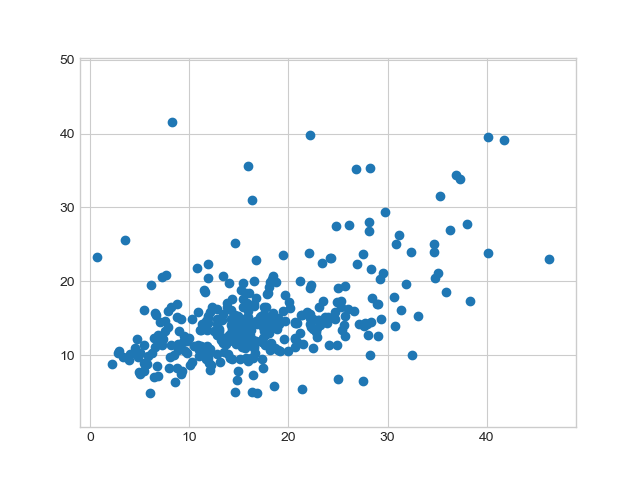

In [269]:
visul_shnn(models_list[-1][-2], models_list[-1][-1])

In [276]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.05, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_list.append((evaluate_model_shuffle(model, x_all, y_all_unscaled, splitter, 50)))

Train data shape:(871, 99), Test data shape:(373, 99)
Train on 871 samples, validate on 373 samples
Epoch 1/50
871/871 [==============================] - 9s 10ms/step - loss: 1793.7881 - mean_absolute_error: 14.9941 - val_loss: 204.5125 - val_mean_absolute_error: 11.9635
Epoch 2/50
871/871 [==============================] - 4s 4ms/step - loss: 314.4267 - mean_absolute_error: 12.1635 - val_loss: 166.2031 - val_mean_absolute_error: 10.0388
Epoch 3/50
871/871 [==============================] - 3s 4ms/step - loss: 178.7257 - mean_absolute_error: 10.5013 - val_loss: 139.2826 - val_mean_absolute_error: 9.3377
Epoch 4/50
871/871 [==============================] - 3s 4ms/step - loss: 225.0860 - mean_absolute_error: 10.1613 - val_loss: 140.7589 - val_mean_absolute_error: 8.9527
Epoch 5/50
871/871 [==============================] - 3s 4ms/step - loss: 191.4533 - mean_absolute_error: 9.5517 - val_loss: 129.6200 - val_mean_absolute_error: 8.8555
Epoch 6/50
871/871 [==============================] 

871/871 [==============================] - 3s 3ms/step - loss: 47.2032 - mean_absolute_error: 5.2984 - val_loss: 65.4794 - val_mean_absolute_error: 5.8003
Epoch 50/50
871/871 [==============================] - 3s 4ms/step - loss: 44.7572 - mean_absolute_error: 5.2066 - val_loss: 64.8607 - val_mean_absolute_error: 5.7982


<IPython.core.display.Javascript object>


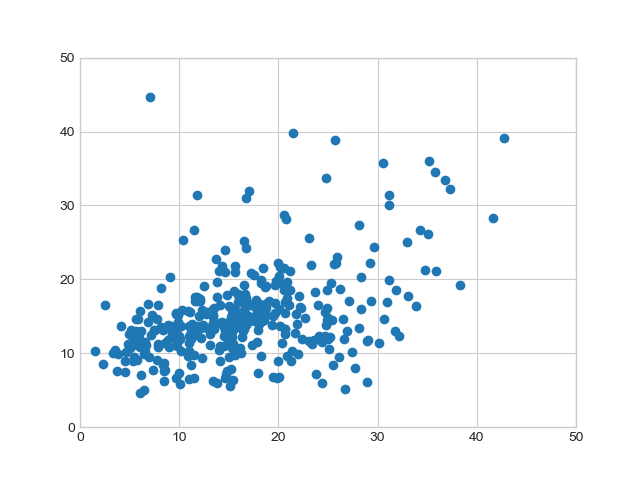

In [277]:
visul_shnn(models_list[-1][-2], models_list[-1][-1])

In [289]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(45, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.05, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_list.append((evaluate_model_shuffle(model, x_all, y_all_unscaled, splitter, 50)))

Train data shape:(871, 99), Test data shape:(373, 99)
Train on 871 samples, validate on 373 samples
Epoch 1/50
871/871 [==============================] - 13s 15ms/step - loss: 492.1983 - mean_absolute_error: 15.0305 - val_loss: 429.8530 - val_mean_absolute_error: 13.0507
Epoch 2/50
871/871 [==============================] - 3s 4ms/step - loss: 555.0489 - mean_absolute_error: 13.7069 - val_loss: 244.6503 - val_mean_absolute_error: 12.9312
Epoch 3/50
871/871 [==============================] - 3s 3ms/step - loss: 255.7730 - mean_absolute_error: 13.2424 - val_loss: 657.9729 - val_mean_absolute_error: 11.7636
Epoch 4/50
871/871 [==============================] - 3s 3ms/step - loss: 347.5476 - mean_absolute_error: 14.3786 - val_loss: 242.2401 - val_mean_absolute_error: 12.8495
Epoch 5/50
871/871 [==============================] - 3s 4ms/step - loss: 279.3239 - mean_absolute_error: 13.9476 - val_loss: 252.9239 - val_mean_absolute_error: 11.8636
Epoch 6/50
871/871 [============================

871/871 [==============================] - 3s 3ms/step - loss: 52.6255 - mean_absolute_error: 5.6512 - val_loss: 355.9930 - val_mean_absolute_error: 6.8659
Epoch 50/50
871/871 [==============================] - 3s 3ms/step - loss: 51.5544 - mean_absolute_error: 5.5754 - val_loss: 391.0133 - val_mean_absolute_error: 6.8702


<IPython.core.display.Javascript object>


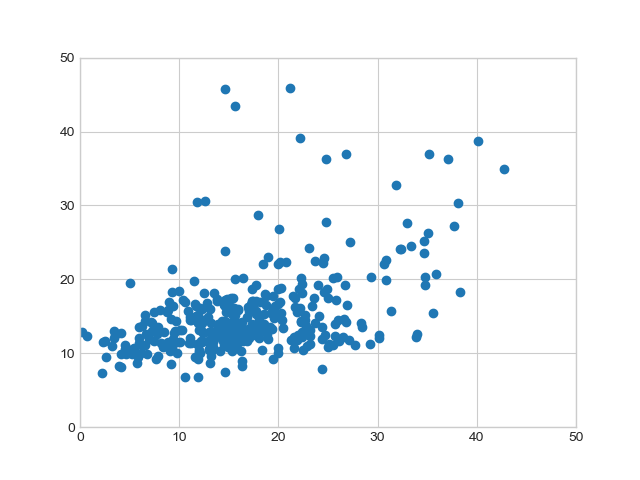

In [290]:
visul_shnn(models_list[-1][-2], models_list[-1][-1])

In [11]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.05, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_list.append((evaluate_model_shuffle(model, x_all, y_all_unscaled, splitter, 50)))

Train data shape:(871, 99), Test data shape:(373, 99)
Train on 871 samples, validate on 373 samples
Epoch 1/50
871/871 [==============================] - 2s 3ms/step - loss: 549.4357 - mean_absolute_error: 13.6500 - val_loss: 1495.8936 - val_mean_absolute_error: 12.9128
Epoch 2/50
871/871 [==============================] - 1s 2ms/step - loss: 888.3632 - mean_absolute_error: 12.7558 - val_loss: 1532.8127 - val_mean_absolute_error: 11.2376
Epoch 3/50
871/871 [==============================] - 1s 2ms/step - loss: 237.6140 - mean_absolute_error: 9.2012 - val_loss: 3531.4261 - val_mean_absolute_error: 12.0443
Epoch 4/50
871/871 [==============================] - 1s 2ms/step - loss: 456.5951 - mean_absolute_error: 9.2407 - val_loss: 2138.3102 - val_mean_absolute_error: 10.2022
Epoch 5/50
871/871 [==============================] - 1s 2ms/step - loss: 363.0687 - mean_absolute_error: 7.8980 - val_loss: 3341.8480 - val_mean_absolute_error: 10.9332
Epoch 6/50
871/871 [============================

871/871 [==============================] - 2s 2ms/step - loss: 10.7094 - mean_absolute_error: 2.4358 - val_loss: 82.3178 - val_mean_absolute_error: 5.2786
Epoch 50/50
871/871 [==============================] - 1s 2ms/step - loss: 10.5439 - mean_absolute_error: 2.4370 - val_loss: 83.7308 - val_mean_absolute_error: 5.2624


<IPython.core.display.Javascript object>


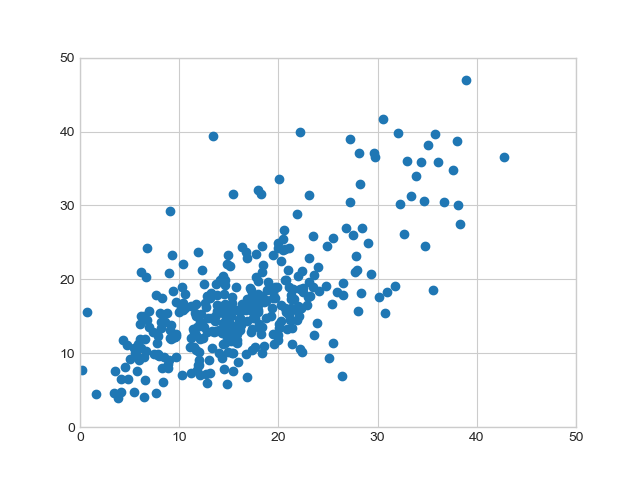

In [14]:
visul_shnn(models_list[-1][-2], models_list[-1][-1])

In [15]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.05, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_list.append((evaluate_model_shuffle(model, x_all, y_all_unscaled, splitter, 50)))

Train data shape:(871, 99), Test data shape:(373, 99)
Train on 871 samples, validate on 373 samples
Epoch 1/50
871/871 [==============================] - 2s 2ms/step - loss: 1917.3459 - mean_absolute_error: 16.3566 - val_loss: 269.1810 - val_mean_absolute_error: 13.0704
Epoch 2/50
871/871 [==============================] - 2s 2ms/step - loss: 795.1877 - mean_absolute_error: 14.2744 - val_loss: 235.5605 - val_mean_absolute_error: 12.4730
Epoch 3/50
871/871 [==============================] - 2s 2ms/step - loss: 521.9309 - mean_absolute_error: 12.4994 - val_loss: 231.0548 - val_mean_absolute_error: 11.7153
Epoch 4/50
871/871 [==============================] - 2s 2ms/step - loss: 353.2709 - mean_absolute_error: 11.6135 - val_loss: 220.8244 - val_mean_absolute_error: 11.1309
Epoch 5/50
871/871 [==============================] - 2s 2ms/step - loss: 442.5675 - mean_absolute_error: 11.2359 - val_loss: 224.4443 - val_mean_absolute_error: 10.6329
Epoch 6/50
871/871 [=============================

871/871 [==============================] - 2s 2ms/step - loss: 45.3576 - mean_absolute_error: 5.2253 - val_loss: 82.6169 - val_mean_absolute_error: 6.1691
Epoch 50/50
871/871 [==============================] - 2s 2ms/step - loss: 51.5659 - mean_absolute_error: 5.4732 - val_loss: 80.8115 - val_mean_absolute_error: 6.1030


<IPython.core.display.Javascript object>


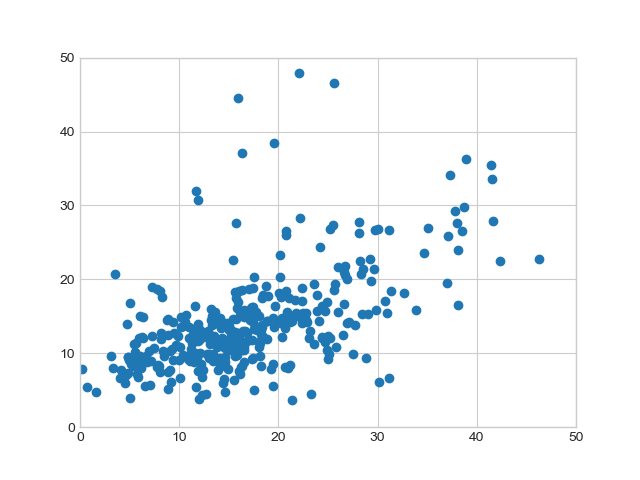

In [16]:
visul_shnn(models_list[-1][-2], models_list[-1][-1])

In [17]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.75))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.05, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_list.append((evaluate_model_shuffle(model, x_all, y_all_unscaled, splitter, 50)))

Train data shape:(871, 99), Test data shape:(373, 99)
Train on 871 samples, validate on 373 samples
Epoch 1/50
871/871 [==============================] - 2s 3ms/step - loss: 3259.5449 - mean_absolute_error: 20.4977 - val_loss: 1010.0927 - val_mean_absolute_error: 15.5116
Epoch 2/50
871/871 [==============================] - 2s 2ms/step - loss: 8862.2073 - mean_absolute_error: 17.0828 - val_loss: 1090.9049 - val_mean_absolute_error: 15.4400
Epoch 3/50
871/871 [==============================] - 2s 2ms/step - loss: 1373.0532 - mean_absolute_error: 13.8057 - val_loss: 396.5007 - val_mean_absolute_error: 14.6296
Epoch 4/50
871/871 [==============================] - 2s 2ms/step - loss: 1046.0356 - mean_absolute_error: 13.1432 - val_loss: 403.3385 - val_mean_absolute_error: 14.5684
Epoch 5/50
871/871 [==============================] - 2s 2ms/step - loss: 388.0317 - mean_absolute_error: 12.6706 - val_loss: 403.7862 - val_mean_absolute_error: 14.5000
Epoch 6/50
871/871 [========================

Epoch 49/50
871/871 [==============================] - 2s 2ms/step - loss: 61.3838 - mean_absolute_error: 5.9966 - val_loss: 304.5761 - val_mean_absolute_error: 9.0942
Epoch 50/50
871/871 [==============================] - 2s 2ms/step - loss: 60.5021 - mean_absolute_error: 6.0235 - val_loss: 316.7747 - val_mean_absolute_error: 8.9541


<IPython.core.display.Javascript object>


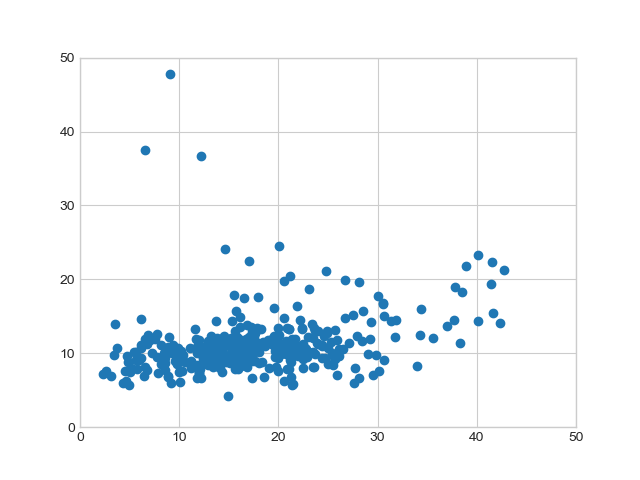

In [18]:
visul_shnn(models_list[-1][-2], models_list[-1][-1])

In [24]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_list.append((evaluate_model_shuffle(model, x_all, y_all_unscaled, splitter, 1000)))

Train data shape:(871, 99), Test data shape:(373, 99)
Train on 871 samples, validate on 373 samples
Epoch 1/1000
871/871 [==============================] - 2s 3ms/step - loss: 1243.8081 - mean_absolute_error: 14.7643 - val_loss: 321.9306 - val_mean_absolute_error: 13.4889
Epoch 2/1000
871/871 [==============================] - 2s 2ms/step - loss: 542.3594 - mean_absolute_error: 12.6661 - val_loss: 350.0930 - val_mean_absolute_error: 12.8983
Epoch 3/1000
871/871 [==============================] - 2s 2ms/step - loss: 405.8579 - mean_absolute_error: 12.0813 - val_loss: 297.9720 - val_mean_absolute_error: 12.9655
Epoch 4/1000
871/871 [==============================] - 2s 2ms/step - loss: 507.8072 - mean_absolute_error: 12.0026 - val_loss: 293.8095 - val_mean_absolute_error: 12.2327
Epoch 5/1000
871/871 [==============================] - 2s 2ms/step - loss: 217.1354 - mean_absolute_error: 10.8293 - val_loss: 271.7362 - val_mean_absolute_error: 11.6995
Epoch 6/1000
871/871 [=================

871/871 [==============================] - 2s 2ms/step - loss: 57.4755 - mean_absolute_error: 5.8033 - val_loss: 97.7731 - val_mean_absolute_error: 6.8915
Epoch 49/1000
871/871 [==============================] - 2s 2ms/step - loss: 56.3082 - mean_absolute_error: 5.6901 - val_loss: 96.7948 - val_mean_absolute_error: 6.8406
Epoch 50/1000
871/871 [==============================] - 2s 2ms/step - loss: 63.5951 - mean_absolute_error: 5.8367 - val_loss: 96.3255 - val_mean_absolute_error: 6.8251
Epoch 51/1000
871/871 [==============================] - 2s 2ms/step - loss: 60.2366 - mean_absolute_error: 5.8189 - val_loss: 93.6849 - val_mean_absolute_error: 6.7664
Epoch 52/1000
871/871 [==============================] - 2s 2ms/step - loss: 51.0503 - mean_absolute_error: 5.4889 - val_loss: 95.4727 - val_mean_absolute_error: 6.7565
Epoch 53/1000
871/871 [==============================] - 2s 2ms/step - loss: 54.0098 - mean_absolute_error: 5.5858 - val_loss: 93.6189 - val_mean_absolute_error: 6.7389


871/871 [==============================] - 2s 2ms/step - loss: 60.0411 - mean_absolute_error: 4.9923 - val_loss: 75.0506 - val_mean_absolute_error: 6.0392
Epoch 97/1000
871/871 [==============================] - 2s 2ms/step - loss: 38.3296 - mean_absolute_error: 4.6794 - val_loss: 72.8510 - val_mean_absolute_error: 6.0141
Epoch 98/1000
871/871 [==============================] - 2s 2ms/step - loss: 35.9470 - mean_absolute_error: 4.5602 - val_loss: 72.5609 - val_mean_absolute_error: 6.0091
Epoch 99/1000
871/871 [==============================] - 2s 2ms/step - loss: 40.3003 - mean_absolute_error: 4.7279 - val_loss: 70.6395 - val_mean_absolute_error: 5.9720
Epoch 100/1000
871/871 [==============================] - 2s 2ms/step - loss: 47.1870 - mean_absolute_error: 4.8851 - val_loss: 69.5853 - val_mean_absolute_error: 5.9556
Epoch 101/1000
871/871 [==============================] - 2s 2ms/step - loss: 41.6110 - mean_absolute_error: 4.8339 - val_loss: 71.0492 - val_mean_absolute_error: 5.943

871/871 [==============================] - 2s 2ms/step - loss: 32.9493 - mean_absolute_error: 4.3162 - val_loss: 63.0858 - val_mean_absolute_error: 5.7558
Epoch 145/1000
871/871 [==============================] - 2s 2ms/step - loss: 31.5438 - mean_absolute_error: 4.3296 - val_loss: 63.1230 - val_mean_absolute_error: 5.7450
Epoch 146/1000
871/871 [==============================] - 2s 2ms/step - loss: 34.4154 - mean_absolute_error: 4.4024 - val_loss: 63.0253 - val_mean_absolute_error: 5.7423
Epoch 147/1000
871/871 [==============================] - 2s 2ms/step - loss: 32.8536 - mean_absolute_error: 4.3431 - val_loss: 63.2450 - val_mean_absolute_error: 5.7469
Epoch 148/1000
871/871 [==============================] - 2s 2ms/step - loss: 31.5619 - mean_absolute_error: 4.2951 - val_loss: 62.8443 - val_mean_absolute_error: 5.7637
Epoch 149/1000
871/871 [==============================] - 2s 2ms/step - loss: 34.3081 - mean_absolute_error: 4.4461 - val_loss: 62.0971 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 27.8641 - mean_absolute_error: 4.0205 - val_loss: 58.0463 - val_mean_absolute_error: 5.6618
Epoch 193/1000
871/871 [==============================] - 2s 2ms/step - loss: 27.3758 - mean_absolute_error: 4.0383 - val_loss: 58.6551 - val_mean_absolute_error: 5.6684
Epoch 194/1000
871/871 [==============================] - 2s 2ms/step - loss: 29.2138 - mean_absolute_error: 4.0459 - val_loss: 58.8838 - val_mean_absolute_error: 5.6503
Epoch 195/1000
871/871 [==============================] - 2s 2ms/step - loss: 31.5381 - mean_absolute_error: 4.1089 - val_loss: 58.7105 - val_mean_absolute_error: 5.6533
Epoch 196/1000
871/871 [==============================] - 2s 2ms/step - loss: 28.4444 - mean_absolute_error: 4.0258 - val_loss: 59.0613 - val_mean_absolute_error: 5.6579
Epoch 197/1000
871/871 [==============================] - 2s 2ms/step - loss: 29.6572 - mean_absolute_error: 4.0761 - val_loss: 59.2292 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 33.8117 - mean_absolute_error: 3.8721 - val_loss: 54.1575 - val_mean_absolute_error: 5.5579
Epoch 241/1000
871/871 [==============================] - 2s 2ms/step - loss: 24.4426 - mean_absolute_error: 3.7803 - val_loss: 54.4324 - val_mean_absolute_error: 5.5522
Epoch 242/1000
871/871 [==============================] - 2s 2ms/step - loss: 24.3218 - mean_absolute_error: 3.7753 - val_loss: 54.6046 - val_mean_absolute_error: 5.5701
Epoch 243/1000
871/871 [==============================] - 2s 2ms/step - loss: 24.0291 - mean_absolute_error: 3.6325 - val_loss: 55.2033 - val_mean_absolute_error: 5.5931
Epoch 244/1000
871/871 [==============================] - 2s 2ms/step - loss: 25.9859 - mean_absolute_error: 3.8580 - val_loss: 55.0338 - val_mean_absolute_error: 5.5844
Epoch 245/1000
871/871 [==============================] - 2s 2ms/step - loss: 23.9750 - mean_absolute_error: 3.7672 - val_loss: 54.0017 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 20.6557 - mean_absolute_error: 3.4021 - val_loss: 53.0711 - val_mean_absolute_error: 5.4952
Epoch 289/1000
871/871 [==============================] - 2s 2ms/step - loss: 22.6904 - mean_absolute_error: 3.6027 - val_loss: 53.2743 - val_mean_absolute_error: 5.4911
Epoch 290/1000
871/871 [==============================] - 2s 2ms/step - loss: 23.3201 - mean_absolute_error: 3.6998 - val_loss: 53.3724 - val_mean_absolute_error: 5.4901
Epoch 291/1000
871/871 [==============================] - 2s 2ms/step - loss: 22.9015 - mean_absolute_error: 3.7188 - val_loss: 53.5132 - val_mean_absolute_error: 5.4943
Epoch 292/1000
871/871 [==============================] - 2s 2ms/step - loss: 21.5381 - mean_absolute_error: 3.5896 - val_loss: 53.0926 - val_mean_absolute_error: 5.4809
Epoch 293/1000
871/871 [==============================] - 2s 2ms/step - loss: 20.9871 - mean_absolute_error: 3.5518 - val_loss: 52.9330 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 21.2680 - mean_absolute_error: 3.5289 - val_loss: 53.4883 - val_mean_absolute_error: 5.4288
Epoch 337/1000
871/871 [==============================] - 2s 2ms/step - loss: 22.3538 - mean_absolute_error: 3.5675 - val_loss: 53.6558 - val_mean_absolute_error: 5.4181
Epoch 338/1000
871/871 [==============================] - 2s 2ms/step - loss: 19.4652 - mean_absolute_error: 3.3760 - val_loss: 53.3501 - val_mean_absolute_error: 5.4306
Epoch 339/1000
871/871 [==============================] - 2s 2ms/step - loss: 22.8630 - mean_absolute_error: 3.5417 - val_loss: 53.3724 - val_mean_absolute_error: 5.4370
Epoch 340/1000
871/871 [==============================] - 2s 2ms/step - loss: 21.6825 - mean_absolute_error: 3.5609 - val_loss: 53.5058 - val_mean_absolute_error: 5.4392
Epoch 341/1000
871/871 [==============================] - 2s 2ms/step - loss: 23.3677 - mean_absolute_error: 3.6620 - val_loss: 53.5959 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 18.8289 - mean_absolute_error: 3.3439 - val_loss: 54.0052 - val_mean_absolute_error: 5.4251
Epoch 385/1000
871/871 [==============================] - 2s 2ms/step - loss: 18.6417 - mean_absolute_error: 3.3324 - val_loss: 53.9999 - val_mean_absolute_error: 5.4140
Epoch 386/1000
871/871 [==============================] - 2s 2ms/step - loss: 19.3043 - mean_absolute_error: 3.3823 - val_loss: 54.0073 - val_mean_absolute_error: 5.4119
Epoch 387/1000
871/871 [==============================] - 2s 2ms/step - loss: 19.0648 - mean_absolute_error: 3.3355 - val_loss: 53.7463 - val_mean_absolute_error: 5.4151
Epoch 388/1000
871/871 [==============================] - 2s 2ms/step - loss: 19.6074 - mean_absolute_error: 3.3119 - val_loss: 53.6372 - val_mean_absolute_error: 5.4225
Epoch 389/1000
871/871 [==============================] - 2s 2ms/step - loss: 20.9146 - mean_absolute_error: 3.4987 - val_loss: 53.8585 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 17.4627 - mean_absolute_error: 3.2115 - val_loss: 54.7923 - val_mean_absolute_error: 5.3858
Epoch 433/1000
871/871 [==============================] - 2s 2ms/step - loss: 18.4945 - mean_absolute_error: 3.2997 - val_loss: 54.5649 - val_mean_absolute_error: 5.3942
Epoch 434/1000
871/871 [==============================] - 2s 2ms/step - loss: 18.6656 - mean_absolute_error: 3.3252 - val_loss: 54.5435 - val_mean_absolute_error: 5.3964
Epoch 435/1000
871/871 [==============================] - 2s 2ms/step - loss: 18.5919 - mean_absolute_error: 3.3117 - val_loss: 54.7237 - val_mean_absolute_error: 5.3972
Epoch 436/1000
871/871 [==============================] - 2s 2ms/step - loss: 16.4111 - mean_absolute_error: 3.1500 - val_loss: 54.8090 - val_mean_absolute_error: 5.3950
Epoch 437/1000
871/871 [==============================] - 2s 2ms/step - loss: 18.1923 - mean_absolute_error: 3.2550 - val_loss: 54.9213 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 18.2615 - mean_absolute_error: 3.2844 - val_loss: 54.5284 - val_mean_absolute_error: 5.3927
Epoch 481/1000
871/871 [==============================] - 2s 2ms/step - loss: 17.9609 - mean_absolute_error: 3.1997 - val_loss: 54.7022 - val_mean_absolute_error: 5.4027
Epoch 482/1000
871/871 [==============================] - 2s 2ms/step - loss: 16.7993 - mean_absolute_error: 3.1599 - val_loss: 54.6305 - val_mean_absolute_error: 5.4088
Epoch 483/1000
871/871 [==============================] - 2s 2ms/step - loss: 21.6402 - mean_absolute_error: 3.2498 - val_loss: 54.5472 - val_mean_absolute_error: 5.3890
Epoch 484/1000
871/871 [==============================] - 2s 2ms/step - loss: 17.8444 - mean_absolute_error: 3.2000 - val_loss: 54.2678 - val_mean_absolute_error: 5.3792
Epoch 485/1000
871/871 [==============================] - 2s 2ms/step - loss: 21.5513 - mean_absolute_error: 3.3063 - val_loss: 54.6283 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 18.7836 - mean_absolute_error: 3.2071 - val_loss: 55.5980 - val_mean_absolute_error: 5.3660
Epoch 529/1000
871/871 [==============================] - 2s 2ms/step - loss: 16.9340 - mean_absolute_error: 3.1004 - val_loss: 55.4739 - val_mean_absolute_error: 5.3691
Epoch 530/1000
871/871 [==============================] - 2s 2ms/step - loss: 18.7220 - mean_absolute_error: 3.2512 - val_loss: 55.8706 - val_mean_absolute_error: 5.3674
Epoch 531/1000
871/871 [==============================] - 2s 2ms/step - loss: 15.9497 - mean_absolute_error: 3.1045 - val_loss: 55.6690 - val_mean_absolute_error: 5.3588
Epoch 532/1000
871/871 [==============================] - 2s 2ms/step - loss: 16.9642 - mean_absolute_error: 3.2066 - val_loss: 55.8289 - val_mean_absolute_error: 5.3583
Epoch 533/1000
871/871 [==============================] - 2s 2ms/step - loss: 16.5238 - mean_absolute_error: 3.0529 - val_loss: 55.9014 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 14.8015 - mean_absolute_error: 2.9513 - val_loss: 57.0567 - val_mean_absolute_error: 5.4065
Epoch 577/1000
871/871 [==============================] - 2s 2ms/step - loss: 15.5676 - mean_absolute_error: 3.0293 - val_loss: 57.1813 - val_mean_absolute_error: 5.4060
Epoch 578/1000
871/871 [==============================] - 2s 2ms/step - loss: 16.3045 - mean_absolute_error: 3.0475 - val_loss: 57.2938 - val_mean_absolute_error: 5.4159
Epoch 579/1000
871/871 [==============================] - 2s 2ms/step - loss: 16.7718 - mean_absolute_error: 3.0896 - val_loss: 56.7545 - val_mean_absolute_error: 5.4094
Epoch 580/1000
871/871 [==============================] - 2s 2ms/step - loss: 15.6508 - mean_absolute_error: 3.0696 - val_loss: 56.9361 - val_mean_absolute_error: 5.4033
Epoch 581/1000
871/871 [==============================] - 2s 2ms/step - loss: 18.7222 - mean_absolute_error: 3.1318 - val_loss: 57.1806 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 16.1810 - mean_absolute_error: 3.1127 - val_loss: 56.6522 - val_mean_absolute_error: 5.3709
Epoch 625/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.6828 - mean_absolute_error: 2.8976 - val_loss: 56.7905 - val_mean_absolute_error: 5.3886
Epoch 626/1000
871/871 [==============================] - 2s 2ms/step - loss: 15.7872 - mean_absolute_error: 3.0559 - val_loss: 56.7866 - val_mean_absolute_error: 5.3743
Epoch 627/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.9194 - mean_absolute_error: 3.0028 - val_loss: 56.8208 - val_mean_absolute_error: 5.3788
Epoch 628/1000
871/871 [==============================] - 2s 2ms/step - loss: 15.1527 - mean_absolute_error: 2.9881 - val_loss: 56.6551 - val_mean_absolute_error: 5.3957
Epoch 629/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.5076 - mean_absolute_error: 2.9299 - val_loss: 56.7542 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 15.2646 - mean_absolute_error: 2.9903 - val_loss: 56.1680 - val_mean_absolute_error: 5.3767
Epoch 673/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.7316 - mean_absolute_error: 2.9026 - val_loss: 56.3696 - val_mean_absolute_error: 5.3727
Epoch 674/1000
871/871 [==============================] - 2s 2ms/step - loss: 15.8590 - mean_absolute_error: 2.9833 - val_loss: 56.5884 - val_mean_absolute_error: 5.3712
Epoch 675/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.2492 - mean_absolute_error: 2.9684 - val_loss: 56.2248 - val_mean_absolute_error: 5.3725
Epoch 676/1000
871/871 [==============================] - 2s 2ms/step - loss: 15.4578 - mean_absolute_error: 2.9883 - val_loss: 56.1748 - val_mean_absolute_error: 5.3638
Epoch 677/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.0897 - mean_absolute_error: 2.8878 - val_loss: 56.1503 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 15.1884 - mean_absolute_error: 3.0010 - val_loss: 56.8696 - val_mean_absolute_error: 5.3678
Epoch 721/1000
871/871 [==============================] - 2s 2ms/step - loss: 13.6946 - mean_absolute_error: 2.8608 - val_loss: 56.9551 - val_mean_absolute_error: 5.3628
Epoch 722/1000
871/871 [==============================] - 2s 2ms/step - loss: 13.4614 - mean_absolute_error: 2.8280 - val_loss: 56.8512 - val_mean_absolute_error: 5.3676
Epoch 723/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.2172 - mean_absolute_error: 2.9367 - val_loss: 56.9802 - val_mean_absolute_error: 5.3597
Epoch 724/1000
871/871 [==============================] - 2s 2ms/step - loss: 15.1354 - mean_absolute_error: 2.9389 - val_loss: 56.7779 - val_mean_absolute_error: 5.3465
Epoch 725/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.0737 - mean_absolute_error: 2.8917 - val_loss: 56.5350 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 14.0467 - mean_absolute_error: 2.8496 - val_loss: 57.2091 - val_mean_absolute_error: 5.3670
Epoch 769/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.6172 - mean_absolute_error: 2.9935 - val_loss: 57.6068 - val_mean_absolute_error: 5.3750
Epoch 770/1000
871/871 [==============================] - 2s 2ms/step - loss: 13.2358 - mean_absolute_error: 2.7971 - val_loss: 57.6080 - val_mean_absolute_error: 5.3739
Epoch 771/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.0080 - mean_absolute_error: 2.8648 - val_loss: 57.8129 - val_mean_absolute_error: 5.3862
Epoch 772/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.7955 - mean_absolute_error: 2.8486 - val_loss: 57.6932 - val_mean_absolute_error: 5.3838
Epoch 773/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.2298 - mean_absolute_error: 2.8583 - val_loss: 57.2488 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 12.9386 - mean_absolute_error: 2.7882 - val_loss: 57.4082 - val_mean_absolute_error: 5.3693
Epoch 817/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.0374 - mean_absolute_error: 2.8449 - val_loss: 57.2859 - val_mean_absolute_error: 5.3702
Epoch 818/1000
871/871 [==============================] - 2s 2ms/step - loss: 13.7911 - mean_absolute_error: 2.8540 - val_loss: 57.1106 - val_mean_absolute_error: 5.3653
Epoch 819/1000
871/871 [==============================] - 2s 2ms/step - loss: 13.1077 - mean_absolute_error: 2.7332 - val_loss: 57.4458 - val_mean_absolute_error: 5.3630
Epoch 820/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.3442 - mean_absolute_error: 2.8871 - val_loss: 57.3443 - val_mean_absolute_error: 5.3636
Epoch 821/1000
871/871 [==============================] - 2s 2ms/step - loss: 15.3167 - mean_absolute_error: 2.9441 - val_loss: 57.5742 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 13.6226 - mean_absolute_error: 2.7923 - val_loss: 57.7871 - val_mean_absolute_error: 5.3598
Epoch 865/1000
871/871 [==============================] - 2s 2ms/step - loss: 13.7290 - mean_absolute_error: 2.8461 - val_loss: 57.5609 - val_mean_absolute_error: 5.3573
Epoch 866/1000
871/871 [==============================] - 2s 2ms/step - loss: 12.9269 - mean_absolute_error: 2.7345 - val_loss: 57.5081 - val_mean_absolute_error: 5.3573
Epoch 867/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.0239 - mean_absolute_error: 2.8250 - val_loss: 57.4056 - val_mean_absolute_error: 5.3560
Epoch 868/1000
871/871 [==============================] - 2s 2ms/step - loss: 14.7063 - mean_absolute_error: 2.8181 - val_loss: 57.2827 - val_mean_absolute_error: 5.3489
Epoch 869/1000
871/871 [==============================] - 2s 2ms/step - loss: 12.6258 - mean_absolute_error: 2.7944 - val_loss: 57.1249 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 12.1075 - mean_absolute_error: 2.6950 - val_loss: 57.1355 - val_mean_absolute_error: 5.3348
Epoch 913/1000
871/871 [==============================] - 2s 2ms/step - loss: 13.0645 - mean_absolute_error: 2.7532 - val_loss: 57.0316 - val_mean_absolute_error: 5.3487
Epoch 914/1000
871/871 [==============================] - 2s 2ms/step - loss: 12.9370 - mean_absolute_error: 2.7892 - val_loss: 57.2210 - val_mean_absolute_error: 5.3534
Epoch 915/1000
871/871 [==============================] - 2s 2ms/step - loss: 12.8828 - mean_absolute_error: 2.7664 - val_loss: 57.2817 - val_mean_absolute_error: 5.3601
Epoch 916/1000
871/871 [==============================] - 2s 2ms/step - loss: 13.1901 - mean_absolute_error: 2.8234 - val_loss: 57.4096 - val_mean_absolute_error: 5.3633
Epoch 917/1000
871/871 [==============================] - 2s 2ms/step - loss: 12.9476 - mean_absolute_error: 2.7728 - val_loss: 57.1579 - val_mean_absolute_error: 5.

871/871 [==============================] - 2s 2ms/step - loss: 12.5271 - mean_absolute_error: 2.6831 - val_loss: 57.7831 - val_mean_absolute_error: 5.3539
Epoch 961/1000
871/871 [==============================] - 2s 2ms/step - loss: 12.3083 - mean_absolute_error: 2.6882 - val_loss: 58.1114 - val_mean_absolute_error: 5.3650
Epoch 962/1000
871/871 [==============================] - 2s 2ms/step - loss: 12.9008 - mean_absolute_error: 2.7512 - val_loss: 57.8815 - val_mean_absolute_error: 5.3649
Epoch 963/1000
871/871 [==============================] - 2s 2ms/step - loss: 12.4881 - mean_absolute_error: 2.6835 - val_loss: 58.1408 - val_mean_absolute_error: 5.3658
Epoch 964/1000
871/871 [==============================] - 2s 2ms/step - loss: 12.6279 - mean_absolute_error: 2.7017 - val_loss: 57.9039 - val_mean_absolute_error: 5.3481
Epoch 965/1000
871/871 [==============================] - 2s 2ms/step - loss: 13.4769 - mean_absolute_error: 2.7454 - val_loss: 58.0264 - val_mean_absolute_error: 5.

<IPython.core.display.Javascript object>


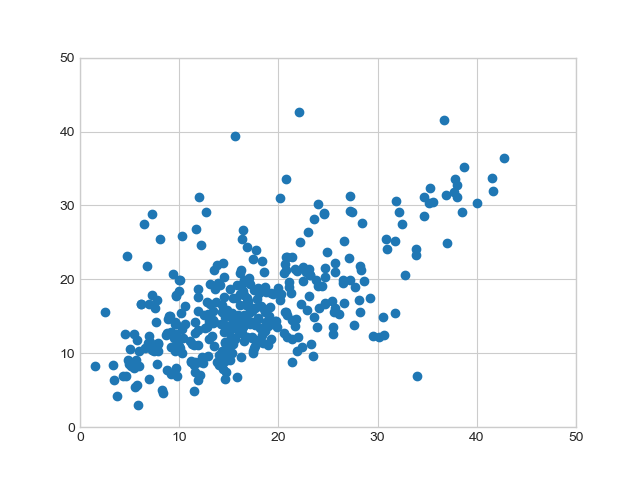

In [25]:
visul_shnn(models_list[-1][-2], models_list[-1][-1])

In [35]:
def evaluate_model_pat(model, X, y, pat_indexes, val_pat, splitter, n_epochs):
       
    all_mae_histories = []
    all_mae_histories_val = []
    ground_truth = []
    predictions = []
    xy_data = pd.concat([X, y], axis=1)
   
    if val_pat not in range(1, 5):
        raise ValueError
        
    if val_pat == 1:
        test_limit = int(pat_indexes.iloc[val_pat])
        test_data = xy_data.iloc[:test_limit, :]
        train_data = xy_data.iloc[test_limit:, :]
    elif val_pat == 4:
        test_limit = int(pat_indexes.iloc[val_pat-1])
        test_data = xy_data.iloc[test_limit:, :]
        train_data = xy_data.iloc[:test_limit, :]
    else:
        test_limit_low = int(pat_indexes.iloc[val_pat-1])
        test_limit_up = int(pat_indexes.iloc[val_pat])
        test_data = xy_data.iloc[test_limit_low:test_limit_up, :]
        train_data = pd.concat([xy_data.iloc[:test_limit_low, :], xy_data.iloc[test_limit_up:, :]], axis=0)
    
    X_train, y_train = split_xy(train_data)
    X_test, y_test = split_xy(test_data)
    print('Train data shape:{}, Test data shape:{}'.format(X_train.shape, X_test.shape))

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=n_epochs, verbose=1, batch_size=1)

    ground_truth.append(y_test)
    preds = model.predict(X_test)
    predictions.append(preds)

    mae_history = history.history['mean_absolute_error']
    mea_history_val = mean_absolute_error(preds, y_test)

    all_mae_histories.append(mae_history)
    all_mae_histories_val.append(mea_history_val)
           
    average_mae_history = [
                np.mean([x[i] for x in all_mae_histories]) for i in range(n_epochs)]
    
    average_mae_history_val = [
                np.mean([x for x in all_mae_histories_val]) for i in range(n_epochs)]
    
    return model, average_mae_history, average_mae_history_val, ground_truth, predictions


In [34]:
models_valpat = [] 

In [40]:
"""PATIENT'S DATA AS A VALIDATION FOLD"""

model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dense(50, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_valpat.append((evaluate_model_pat(model, x_all, y_all_unscaled, pat_indexes, 1, splitter, 50)))

Train data shape:(948, 99), Test data shape:(296, 99)
Train on 948 samples, validate on 296 samples
Epoch 1/50
948/948 [==============================] - 3s 3ms/step - loss: 576.8948 - mean_absolute_error: 10.6962 - val_loss: 762.0411 - val_mean_absolute_error: 22.7081
Epoch 2/50
948/948 [==============================] - 2s 2ms/step - loss: 131.4013 - mean_absolute_error: 8.4169 - val_loss: 843.6160 - val_mean_absolute_error: 21.6040
Epoch 3/50
948/948 [==============================] - 2s 2ms/step - loss: 78.6236 - mean_absolute_error: 7.2423 - val_loss: 715.8147 - val_mean_absolute_error: 20.6770
Epoch 4/50
948/948 [==============================] - 2s 2ms/step - loss: 62.9833 - mean_absolute_error: 6.5260 - val_loss: 653.1836 - val_mean_absolute_error: 19.9394
Epoch 5/50
948/948 [==============================] - 2s 2ms/step - loss: 54.2115 - mean_absolute_error: 6.0033 - val_loss: 635.4452 - val_mean_absolute_error: 19.2807
Epoch 6/50
948/948 [==============================] - 2s 

Epoch 49/50
948/948 [==============================] - 1s 2ms/step - loss: 11.3674 - mean_absolute_error: 2.5889 - val_loss: 1221.9448 - val_mean_absolute_error: 18.4539
Epoch 50/50
948/948 [==============================] - 1s 1ms/step - loss: 11.2329 - mean_absolute_error: 2.5678 - val_loss: 1220.4956 - val_mean_absolute_error: 18.5069


<IPython.core.display.Javascript object>


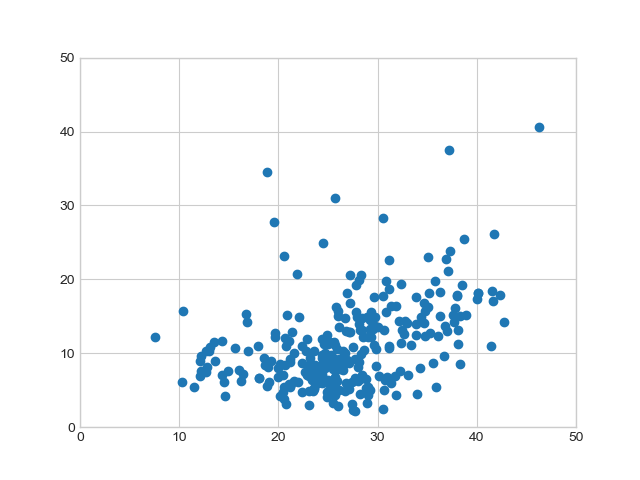

In [41]:
visul_shnn(models_valpat[-1][-2], models_valpat[-1][-1])

In [42]:

model = models.Sequential()
model.add(layers.Dense(50, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dense(20, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_valpat.append((evaluate_model_pat(model, x_all, y_all_unscaled, pat_indexes, 1, splitter, 50)))

Train data shape:(948, 99), Test data shape:(296, 99)
Train on 948 samples, validate on 296 samples
Epoch 1/50
948/948 [==============================] - 2s 2ms/step - loss: 241.9708 - mean_absolute_error: 10.2708 - val_loss: 594.6193 - val_mean_absolute_error: 22.2714
Epoch 2/50
948/948 [==============================] - 1s 1ms/step - loss: 160.0708 - mean_absolute_error: 8.8516 - val_loss: 616.1827 - val_mean_absolute_error: 21.2115
Epoch 3/50
948/948 [==============================] - 1s 1ms/step - loss: 89.8970 - mean_absolute_error: 7.8172 - val_loss: 645.3614 - val_mean_absolute_error: 20.7309
Epoch 4/50
948/948 [==============================] - 1s 1ms/step - loss: 72.7525 - mean_absolute_error: 7.1517 - val_loss: 673.2562 - val_mean_absolute_error: 20.4044
Epoch 5/50
948/948 [==============================] - 1s 1ms/step - loss: 63.7171 - mean_absolute_error: 6.6806 - val_loss: 709.8683 - val_mean_absolute_error: 20.1528
Epoch 6/50
948/948 [==============================] - 1s 

Epoch 49/50
948/948 [==============================] - 2s 2ms/step - loss: 18.9900 - mean_absolute_error: 3.4661 - val_loss: 1477.4331 - val_mean_absolute_error: 18.6993
Epoch 50/50
948/948 [==============================] - 2s 2ms/step - loss: 18.8207 - mean_absolute_error: 3.4514 - val_loss: 1485.3027 - val_mean_absolute_error: 18.6931


<IPython.core.display.Javascript object>


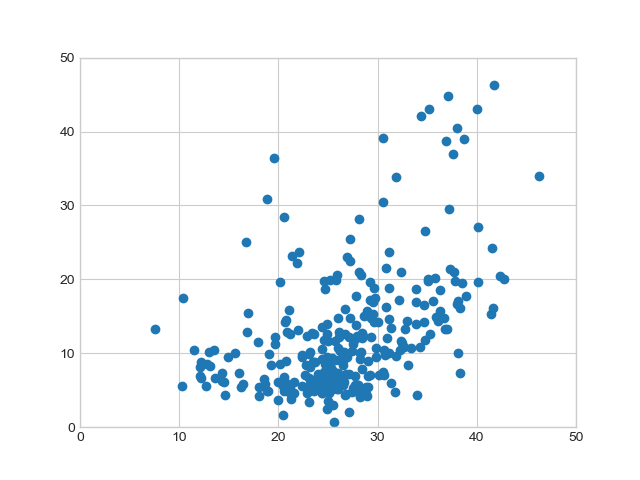

In [43]:
visul_shnn(models_valpat[-1][-2], models_valpat[-1][-1])

In [ ]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_valpat.append((evaluate_model_pat(model, x_all, y_all_unscaled, pat_indexes, 2, splitter, 500)))

In [ ]:
visul_shnn(models_valpat[-1][-2], models_valpat[-1][-1])

In [ ]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_valpat.append((evaluate_model_pat(model, x_all, y_all_unscaled, pat_indexes, 3, splitter, 500)))

In [ ]:
visul_shnn(models_valpat[-1][-2], models_valpat[-1][-1])

In [ ]:
model = models.Sequential()
model.add(layers.Dense(80, activation='relu',
                       input_shape=(99,)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1))

optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

splitter = ShuffleSplit(n_splits=1)
models_valpat.append((evaluate_model_pat(model, x_all, y_all_unscaled, pat_indexes, 4, splitter, 4000)))

In [ ]:
visul_shnn(models_valpat[-1][-2], models_valpat[-1][-1])

In [181]:
models_valpat[1][1][-1]

5.527804483592762

In [201]:
data_patval = {}
data_patval['1'] = {}
data_patval['1']['mae'] = models_valpat[1][1][-1]
data_patval['1']['mae_val'] = models_valpat[1][2][-1]
data_patval['1']['gt'] = list(*models_valpat[1][3])
data_patval['1']['preds'] = list(*models_valpat[1][4][0].T)

data_patval['2'] = {}
data_patval['2']['mae'] = models_valpat[2][1][-1]
data_patval['2']['mae_val'] = models_valpat[2][2][-1]
data_patval['2']['gt'] = list(*models_valpat[2][3])
data_patval['2']['preds'] = list(*models_valpat[2][4][0].T)

data_patval['3'] = {}
data_patval['3']['mae'] = models_valpat[3][1][-1]
data_patval['3']['mae_val'] = models_valpat[3][2][-1]
data_patval['3']['gt'] = list(*models_valpat[3][3])
data_patval['3']['preds'] = list(*models_valpat[3][4][0].T)

data_patval['4'] = {}
data_patval['4']['mae'] = models_valpat[4][1][-1]
data_patval['4']['mae_val'] = models_valpat[4][2][-1]
data_patval['4']['gt'] = list(*models_valpat[4][3])
data_patval['4']['preds'] = list(*models_valpat[4][4][0].T)

In [209]:
dumped2 = json.dumps(data_patval, cls=NumpyEncoder)

with open('data_patval.json', 'w') as fp:
    json.dump(dumped2, fp)

with open('data_patval.json', 'r') as fp: 
    fs = json.load(fp)

fs = json.loads(fs)


In [211]:
fs['1']

{'mae': 5.527804483592762,
 'mae_val': 16.506793023212538,
 'gt': [13.491999999999996,
  12.230999999999995,
  14.960000000000004,
  14.611,
  12.08900000000001,
  20.797000000000004,
  15.583999999999993,
  16.233000000000004,
  16.724,
  24.656999999999996,
  20.537,
  25.741000000000003,
  24.919,
  19.032000000000004,
  21.361,
  25.794000000000004,
  28.918000000000003,
  29.49600000000001,
  27.911,
  22.008000000000003,
  19.22800000000001,
  26.129,
  25.202000000000005,
  26.067,
  21.142,
  24.480999999999998,
  26.524,
  28.188,
  21.528,
  27.087,
  16.056000000000004,
  18.901,
  19.956,
  12.737,
  29.326,
  16.824,
  24.91500000000001,
  21.883000000000003,
  28.029000000000003,
  27.808,
  24.698,
  31.779000000000003,
  34.70400000000001,
  38.50600000000001,
  19.667,
  31.19100000000001,
  35.77100000000001,
  37.299,
  38.702,
  36.109,
  24.60899999999999,
  29.49400000000001,
  32.34,
  37.808,
  29.685,
  28.165,
  28.463,
  26.029000000000003,
  31.14,
  27.8630

          0         0
0  1.000000  0.469512
0  0.469512  1.000000 0.21405108616189905 69


<IPython.core.display.Javascript object>


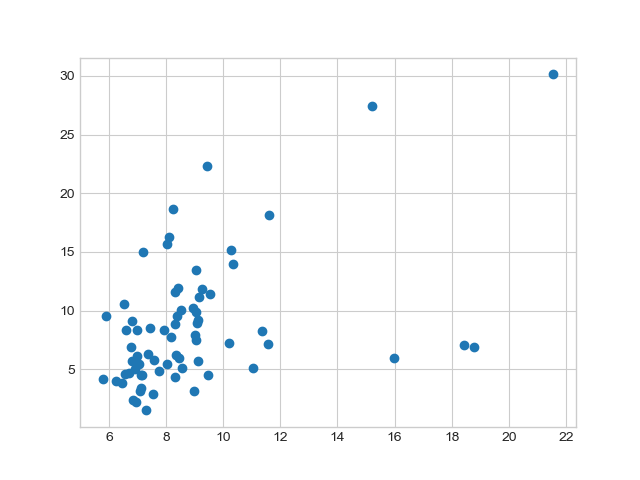

In [141]:
corr_nn_6, r2_nn_6 = get_correlation_and_r2(gt_6, preds_6, mae_avrg_val_f_6)

print(corr_nn_6, r2_nn_6, len(preds_6[0]))

plt.figure()
ca = plt.gca()
ca.scatter(preds_6, gt_6)
#ca.set_xlim(10, 50)

#ca.set_ylim(5, 45)

<IPython.core.display.Javascript object>


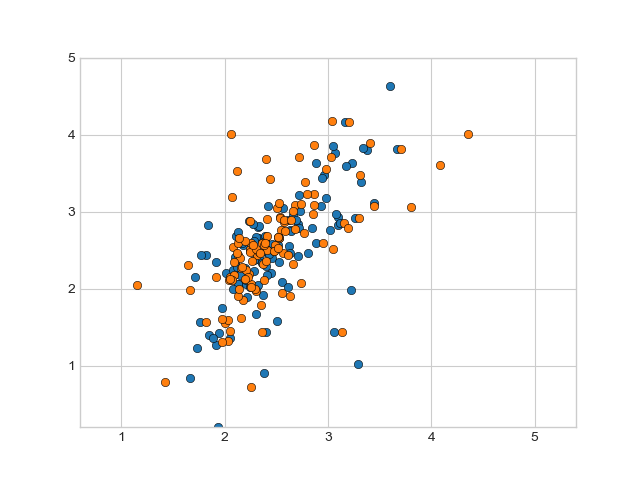

(0.2, 5.0)

In [142]:
less_mae_idx = np.argmin(mae_1)

plt.figure()
ca = plt.gca()
ca.scatter(np.array(preds_1)/10, np.array(gt_1)/10, edgecolors='k', linewidths=0.4)
ca.scatter(pred_1[less_mae_idx]/10, ground_truth_1[less_mae_idx]/10, edgecolors='k', linewidths=0.4)
ca.set_xlim(0.6, 5.4)
ca.set_ylim(0.2, 5.0)

<IPython.core.display.Javascript object>


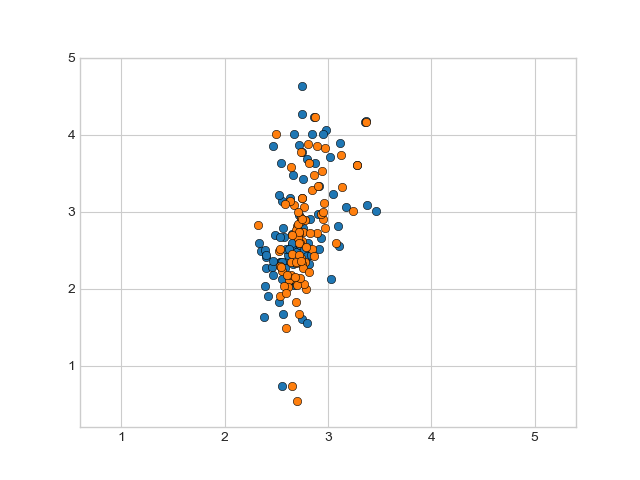

(0.2, 5.0)

In [382]:
less_mae_idx = np.argmin(mae_1)

plt.figure()
ca = plt.gca()
ca.scatter(np.array(preds_1)/10, np.array(gt_1)/10, edgecolors='k', linewidths=0.4)
ca.scatter(pred_1[less_mae_idx]/10, ground_truth_1[less_mae_idx]/10, edgecolors='k', linewidths=0.4)
ca.set_xlim(0.6, 5.4)
ca.set_ylim(0.2, 5.0)

<IPython.core.display.Javascript object>


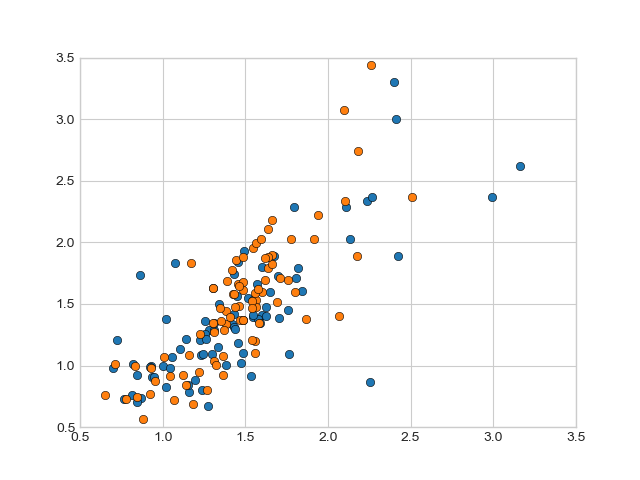

(0.5, 3.5)

In [143]:
less_mae_idx = np.argmin(mae_4)

plt.figure()
ca = plt.gca()
ca.scatter(np.array(preds_4)/10, np.array(gt_4)/10, edgecolors='k', linewidths=0.4)
ca.scatter(pred_4[less_mae_idx]/10, ground_truth_4[less_mae_idx]/10, edgecolors='k', linewidths=0.4)
ca.set_xlim(0.5, 3.5)
ca.set_ylim(0.5, 3.5)

<IPython.core.display.Javascript object>


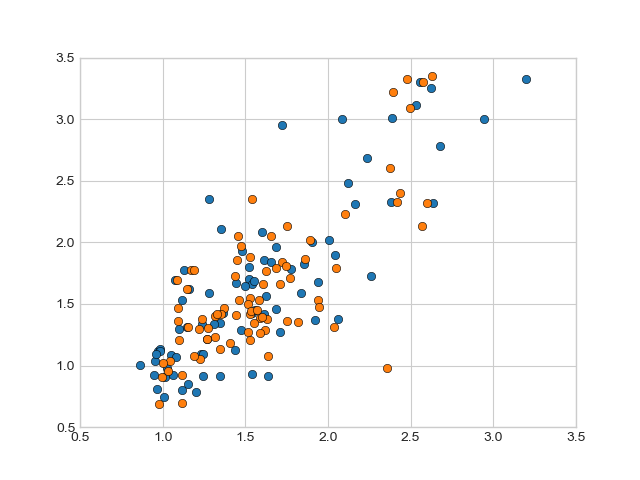

(0.5, 3.5)

In [386]:
less_mae_idx = np.argmin(mae_4)

plt.figure()
ca = plt.gca()
ca.scatter(np.array(preds_4)/10, np.array(gt_4)/10, edgecolors='k', linewidths=0.4)
ca.scatter(pred_4[less_mae_idx]/10, ground_truth_4[less_mae_idx]/10, edgecolors='k', linewidths=0.4)
ca.set_xlim(0.5, 3.5)
ca.set_ylim(0.5, 3.5)

<IPython.core.display.Javascript object>


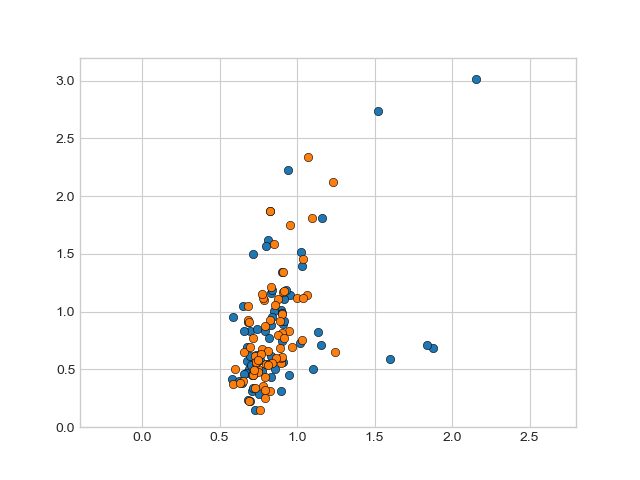

(0, 3.2)

In [144]:
less_mae_idx = np.argmin(mae_6)

plt.figure()
ca = plt.gca()
ca.scatter(np.array(preds_6)/10, np.array(gt_6)/10, edgecolors='k', linewidths=0.4)
ca.scatter(pred_6[less_mae_idx]/10, ground_truth_6[less_mae_idx]/10, edgecolors='k', linewidths=0.4)
ca.set_xlim(-0.4, 2.8)
ca.set_ylim(0, 3.2)

<IPython.core.display.Javascript object>


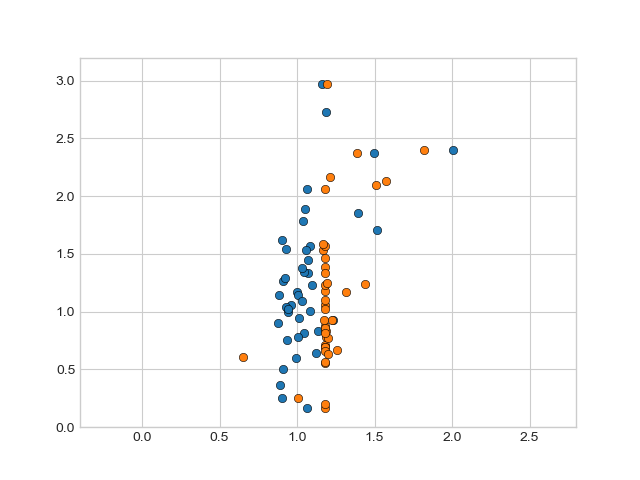

(0, 3.2)

In [393]:
less_mae_idx = np.argmin(mae_6)

plt.figure()
ca = plt.gca()
ca.scatter(np.array(preds_6)/10, np.array(gt_6)/10, edgecolors='k', linewidths=0.4)
ca.scatter(pred_6[less_mae_idx]/10, ground_truth_6[less_mae_idx]/10, edgecolors='k', linewidths=0.4)
ca.set_xlim(-0.4, 2.8)
ca.set_ylim(0, 3.2)

<IPython.core.display.Javascript object>


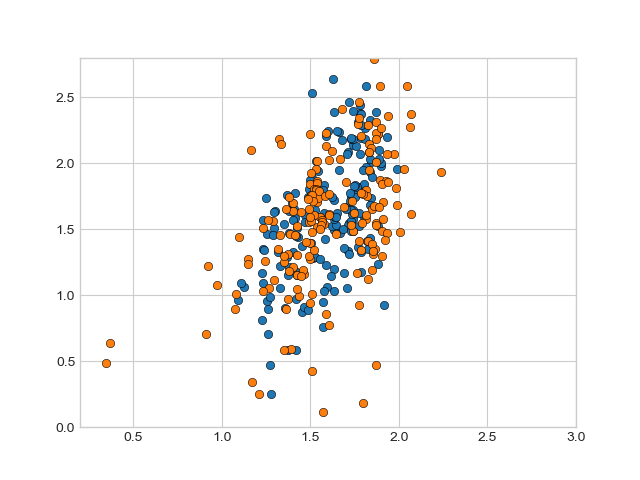

(0, 2.8)

In [145]:
less_mae_idx = np.argmin(mae_7)

plt.figure()
ca = plt.gca()
ca.scatter(np.array(preds_7)/10, np.array(gt_7)/10, edgecolors='k', linewidths=0.4)
ca.scatter(pred_7[less_mae_idx]/10, ground_truth_7[less_mae_idx]/10, edgecolors='k', linewidths=0.4)
ca.set_xlim(0.2, 3)
ca.set_ylim(0, 2.8)

<IPython.core.display.Javascript object>


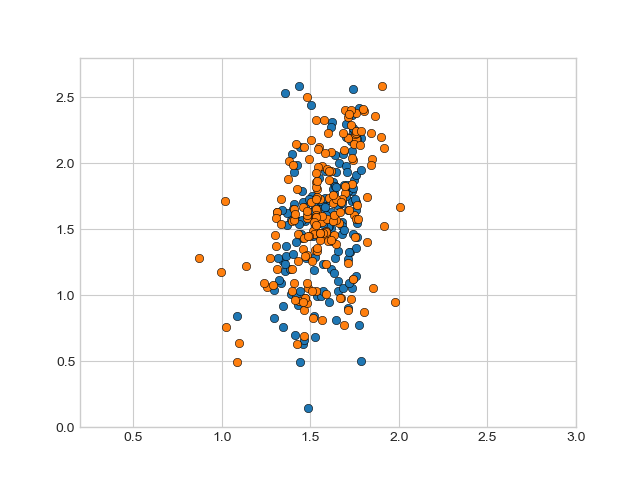

(0, 2.8)

In [397]:
less_mae_idx = np.argmin(mae_7)

plt.figure()
ca = plt.gca()
ca.scatter(np.array(preds_7)/10, np.array(gt_7)/10, edgecolors='k', linewidths=0.4)
ca.scatter(pred_7[less_mae_idx]/10, ground_truth_7[less_mae_idx]/10, edgecolors='k', linewidths=0.4)
ca.set_xlim(0.2, 3)
ca.set_ylim(0, 2.8)

In [363]:
len(preds_1[0]), len(pred_1[0])

(85, 85)